# Generative Adversarial Network: MNIST with PyTorch

- GANs are unsupervised learning algorithms and therefore do not require labels.

- Training GAN(s) is hard since we have two neural networks.

- We also need two learning rate and this can be hard to find a good ratio between the two. It can happen that the discriminator LR is larger than the generator LR, and vice-versa. These have to be tuned and also increases the complexity.


- [YouTube Reference](https://www.youtube.com/watch?v=cTlxZ1FO1mY)

- [GitHub](https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L18)

- [GAN slides](https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L18_gan__slides.pdf)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 50
batch_size = 256

In [7]:
# We have two learning rates:

# Generator LR-
generator_learning_rate = 0.0012

# Discriminator LR-
discriminator_learning_rate = 0.0012

### Load and pre-process MNIST dataset

In [8]:
# MNIST dataset statistics:

# mean = np.array([0.1307])
# std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean = mean, std = std_dev)
    transforms.Normalize(mean = (0.5,), std = (0.5,))
    ])

In [9]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        transform = transforms_apply
        )

print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [10]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [11]:
# Sanity check-
for images, labels in train_loader:
    print(f"image shape: {images.shape}, label shape: {labels.shape}")
    break

image shape: torch.Size([256, 1, 28, 28]), label shape: torch.Size([256])


In [12]:
print(f"Train images; min pixel value = {images.data.min()} & max pixel value = {images.data.max()}")

Train images; min pixel value = -1.0 & max pixel value = 1.0


In [13]:
# Sanity check-
for images, labels in test_loader:
    print(f"image shape: {images.shape}, label shape: {labels.shape}")
    break

image shape: torch.Size([256, 1, 28, 28]), label shape: torch.Size([256])


In [14]:
print(f"Test images; min pixel value = {images.data.min()} & max pixel value = {images.data.max()}")

Test images; min pixel value = -1.0 & max pixel value = 1.0


In [15]:
# Sanity check-
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

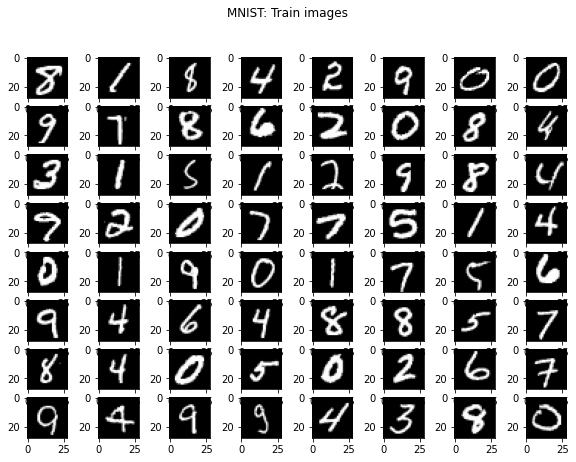

In [16]:
# Print 64 images from training set-
plt.figure(figsize = (10, 7))
for i in range(64):
    # 8 rows & 8 columns-
    plt.subplot(8, 8, i + 1)
    # '0' to access first channel-
    plt.imshow(X[i][0], cmap = 'gray')

plt.suptitle("MNIST: Train images")
plt.show()

### Design _GAN_ architecture

- Since the input data has been normalized to be in the range: [-1, 1], ```tanh``` activation function is used in the _generator_ and _discriminator_.

- Fully-connected GAN architecture is being implemented.

- The _discriminator_ is just a binary classifier.

In [17]:
class GAN_Discriminator(nn.Module):
    def __init__(
        self, image_height = 28,
        image_width = 28, color_channels = 1
    ):
        super(GAN_Discriminator, self).__init__()
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.flatten = nn.Flatten()
        self.layer = nn.Linear(in_features = self.image_height * self.image_width * self.color_channels, out_features = 128)
        self.dropout = nn.Dropout(p = 0.5)
        self.output = nn.Linear(in_features = 128, out_features = 1)
    
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.leaky_relu(self.dropout(self.layer(x)))
        # x = self.dropout(nn.LeakyReLU(self.layer(x)))
        x = torch.tanh(self.output(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape to Discriminator: {x.shape}")
        x = self.flatten(x)
        print(f"Flattened shape: {x.shape}")
        x = F.leaky_relu(self.dropout(self.layer(x)))
        print(f"First dense layer output shape: {x.shape}")
        x = torch.tanh(self.output(x))
        print(f"Discriminator output shape: {x.shape}")
        return None
    
    

In [18]:
class GAN_Generator(nn.Module):
    '''
    Generator receives its input from noise. The noise has the dimension: NCHW.
    The noise vector is sampled from a normal distribution.
    '''
    def __init__(
        self, latent_dim = 100,
        image_height = 28, image_width = 28,
        color_channels = 1
    ):
        super(GAN_Generator, self).__init__()
        self.latent_dim = latent_dim
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.layer = nn.Linear(in_features = self.latent_dim, out_features = 128)
        self.dropout = nn.Dropout(p = 0.5)
        self.layer2 = nn.Linear(in_features = 128, out_features = 300) 
        self.generator_output = nn.Linear(in_features = 300, out_features = self.image_height * self.image_width * self.color_channels)
        
        self.weights_initialization()
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                # nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        '''
        The noise vector 'x' has the shape: NCHW. Or,
        batch-size, number of channels, height, width.
        '''
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dropout(self.layer(x)))
        # x = self.dropout(nn.LeakyReLU(self.layer(x)))
        x = F.leaky_relu(self.dropout(self.layer2(x)))
        x = torch.tanh(self.generator_output(x))
        x = x.view(x.size(0), self.color_channels, self.image_height, self.image_width)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape to Generator: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        print(f"Reshaped shape: {x.shape}")
        x = F.leaky_relu(self.dropout(self.layer(x)))
        print(f"First dense layer output shape: {x.shape}")
        x = F.leaky_relu(self.dropout(self.layer2(x)))
        print(f"Second dense layer output shape: {x.shape}")
        x = torch.tanh(self.generator_output(x))
        print(f"Generator output shape: {x.shape}")
        x = x.view(x.size(0), self.color_channels, self.image_height, self.image_width)
        print(f"Generator reshaped output shape: {x.shape}")
        return None
    

In [19]:
class GAN(nn.Module):
    def __init__(
        self, latent_dim = 100,
        image_height = 28, image_width = 28,
        color_channels = 1
    ):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = GAN_Generator(
            latent_dim = self.latent_dim, image_height = self.image_height,
            image_width = self.image_width, color_channels = self.color_channels
        )
        
        self.discriminator = GAN_Discriminator(
            image_height = self.image_height, image_width = self.image_width,
            color_channels = self.color_channels
        )
    
    """
    def forward(self, x, z):
        img = self.generator(z)
        logits = self.discriminator(img)
    """
    
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits
        
        

In [20]:
# Initialize GAN model and push to 'device'-
model = GAN(
    latent_dim = 100, image_height = 28,
    image_width = 28, color_channels = 1
).to(device)

In [21]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"\nFully-connected GAN has {tot_params} parameters\n")

layer.shape = torch.Size([128, 100]) has 12800 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([300, 128]) has 38400 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([784, 300]) has 235200 parameters
layer.shape = torch.Size([784]) has 784 parameters
layer.shape = torch.Size([128, 784]) has 100352 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([1, 128]) has 128 parameters
layer.shape = torch.Size([1]) has 1 parameters

Fully-connected GAN has 388221 parameters



In [22]:
print(f"\nFully-connected GAN model's layer names are:")
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")


Fully-connected GAN model's layer names are:
generator.layer.weight has dimension = torch.Size([128, 100])
generator.layer.bias has dimension = torch.Size([128])
generator.layer2.weight has dimension = torch.Size([300, 128])
generator.layer2.bias has dimension = torch.Size([300])
generator.generator_output.weight has dimension = torch.Size([784, 300])
generator.generator_output.bias has dimension = torch.Size([784])
discriminator.layer.weight has dimension = torch.Size([128, 784])
discriminator.layer.bias has dimension = torch.Size([128])
discriminator.output.weight has dimension = torch.Size([1, 128])
discriminator.output.bias has dimension = torch.Size([1])


In [23]:
# Initialize gradient descent optimizers-
'''
The optimizer should only update the parameters for their respective
models. Using 'model.parameters' will update both the discriminator
and the generator.
'''

# You might try with SGD for the generator.
optimizer_generator = torch.optim.Adam(
    model.generator.parameters(), betas = (0.5, 0.999),
    lr = generator_learning_rate
)

optimizer_discriminator = torch.optim.Adam(
    model.discriminator.parameters(), betas = (0.5, 0.999),
    lr = discriminator_learning_rate
)

In [24]:
# Define loss objective-
loss_fn = F.binary_cross_entropy_with_logits

### Training

In [25]:
# Specify latent space dimensionality-
latent_dim = 100

In [26]:
# Generate batch of latent noise vector for evaluating/visualizing
# the training progress of generator-
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device = device)

In [27]:
fixed_noise.shape

torch.Size([256, 100, 1, 1])

In [28]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [29]:
# Losses for saving 'best' individual generator and
# discriminator models-
best_generator_loss = 10000
best_discriminator_loss = 10000

In [33]:
def train_one_epoch(model, train_dataset, dataloader, loss_fn, latent_dim = 100):
    '''
    Train GAN model for one epoch using supplied parameters/objects.
    '''
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()

    
    for batch_idx, (features, _) in tqdm(
        enumerate(dataloader), total = int(len(train_dataset) / dataloader.batch_size)
    ):
        local_batch_size = features.size(0)
        
        # Real/actual images-
        real_images = features.to(device)
        
        # Create real labels (all ones)-
        real_labels = torch.ones(local_batch_size, device = device)
        
        # Generated/fake images-
        noise = torch.randn(local_batch_size, latent_dim, 1, 1, device = device)
        # Sampled from a normal distribution. Works better as compared to a
        # uniform distribution.
        
        # Create fake images using GAN's generator from noise-
        fake_images = model.generator_forward(noise)
        
        # Create fake labels (all zeroes)-
        fake_labels = torch.zeros(local_batch_size, device = device)
        
        # Create flipped fake labels. Our trick of fooling the discriminator when
        # training the generator-
        flipped_fake_labels = real_labels
        
        
        # Train Discriminator:
        
        # Empty accumulated gradients-
        optimizer_discriminator.zero_grad()
        
        # Compute discriminator loss on real images-
        discriminator_pred_real = model.discriminator_forward(real_images).view(-1)
        # Convert from (N, 1) -> N; just removing the last dimension. Can also use torch.squeeze().
        
        real_loss = loss_fn(discriminator_pred_real, real_labels)
        # real_loss.backward()
        
        # Compute discriminator loss on fake images-
        discriminator_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        # We are not optimizing the generator here. The generator is frozen. Using detach to
        # remove it from the generator graph.
        
        fake_loss = loss_fn(discriminator_pred_fake, fake_labels)
        # fake_loss.backward()
        
        # Total combined loss-
        discriminator_loss = 0.5 * (real_loss + fake_loss)
        
        # Perform backward propagation-
        discriminator_loss.backward()
        
        # Update parameters for discriminator-
        optimizer_discriminator.step()
        
        
        # Train Generator:
        
        # Empty accumulated gradients-
        optimizer_generator.zero_grad()
        
        # Compute discriminator loss on fake images using flipped labels-
        discriminator_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_fn(discriminator_pred_fake, flipped_fake_labels)
        
        # Perform backward propagation-
        gener_loss.backward()
        
        # Update parameters for discriminator-
        optimizer_generator.step()
        
        # We are only updating the generator here. The parameters for the discriminator remain
        # frozen. The generator is updated such that in the next iteration, it is better at
        # fooling the discriminator by getting the outputs as 1s for 'discriminator_pred_fake'
        # above which are similar to 'fake_labels' by making them similar.
    
    
    return gener_loss.item(), discriminator_loss.item()
        

In [31]:
print(f"Train GAN model for {num_epochs} epochs")

Train GAN model for 50 epochs


In [34]:
for epoch in range(num_epochs):
    
    # Train GAN for one epoch-
    generator_epoch_loss, discriminator_epoch_loss = train_one_epoch(
        model = model, train_dataset = train_dataset,
        dataloader = train_loader, loss_fn = loss_fn,
        latent_dim = latent_dim
    )
    
    print(f"Epoch = {epoch + 1}; training generator loss = {generator_epoch_loss:.5f}"
          f" & train discriminator loss per batch =  {discriminator_epoch_loss:.5f}")
    
    if generator_epoch_loss < best_generator_loss:
        # Update 'best' generator loss-
        best_generator_loss = generator_epoch_loss
        
        # Save 'best' parameters for generator-
        torch.save(model.generator.state_dict(), 'GAN_Fully_Connected_MNIST_best_generator_parameters.pth')
    
    if discriminator_epoch_loss < best_discriminator_loss:
        # Update 'best' discriminator loss-
        best_discriminator_loss = discriminator_epoch_loss
        
        # Save 'best' parameters for generator-
        torch.save(model.discriminator.state_dict(), 'GAN_Fully_Connected_MNIST_best_discriminator_parameters.pth')
        
    # Save training metrics-
    training_metrics[epoch] = {
        'train_generator_loss_per_batch': generator_epoch_loss,
        'train_discriminator_loss_per_batch': discriminator_epoch_loss
    }
    
    

235it [00:05, 39.62it/s]                                                                                                                                                                                                                


Epoch = 1; training generator loss = 1.01558 & train discriminator loss per batch =  0.63972


235it [00:05, 43.90it/s]                                                                                                                                                                                                                


Epoch = 2; training generator loss = 0.89828 & train discriminator loss per batch =  0.60546


235it [00:05, 46.90it/s]                                                                                                                                                                                                                


Epoch = 3; training generator loss = 0.80189 & train discriminator loss per batch =  0.64122


235it [00:05, 46.81it/s]                                                                                                                                                                                                                


Epoch = 4; training generator loss = 0.73886 & train discriminator loss per batch =  0.66935


235it [00:05, 46.79it/s]                                                                                                                                                                                                                


Epoch = 5; training generator loss = 0.72165 & train discriminator loss per batch =  0.69713


235it [00:05, 46.81it/s]                                                                                                                                                                                                                


Epoch = 6; training generator loss = 0.76363 & train discriminator loss per batch =  0.68102


235it [00:05, 46.73it/s]                                                                                                                                                                                                                


Epoch = 7; training generator loss = 0.70412 & train discriminator loss per batch =  0.69110


235it [00:04, 47.24it/s]                                                                                                                                                                                                                


Epoch = 8; training generator loss = 0.76671 & train discriminator loss per batch =  0.68159


235it [00:04, 47.29it/s]                                                                                                                                                                                                                


Epoch = 9; training generator loss = 0.67500 & train discriminator loss per batch =  0.63965


235it [00:04, 47.00it/s]                                                                                                                                                                                                                


Epoch = 10; training generator loss = 0.76809 & train discriminator loss per batch =  0.68365


235it [00:04, 47.37it/s]                                                                                                                                                                                                                


Epoch = 11; training generator loss = 0.68331 & train discriminator loss per batch =  0.68596


235it [00:04, 47.24it/s]                                                                                                                                                                                                                


Epoch = 12; training generator loss = 0.68546 & train discriminator loss per batch =  0.68925


235it [00:04, 47.14it/s]                                                                                                                                                                                                                


Epoch = 13; training generator loss = 0.71467 & train discriminator loss per batch =  0.67691


235it [00:04, 47.47it/s]                                                                                                                                                                                                                


Epoch = 14; training generator loss = 0.71530 & train discriminator loss per batch =  0.68579


235it [00:04, 47.53it/s]                                                                                                                                                                                                                


Epoch = 15; training generator loss = 0.71801 & train discriminator loss per batch =  0.68640


235it [00:04, 47.53it/s]                                                                                                                                                                                                                


Epoch = 16; training generator loss = 0.69810 & train discriminator loss per batch =  0.70158


235it [00:04, 47.58it/s]                                                                                                                                                                                                                


Epoch = 17; training generator loss = 0.70059 & train discriminator loss per batch =  0.69415


235it [00:04, 47.53it/s]                                                                                                                                                                                                                


Epoch = 18; training generator loss = 0.70327 & train discriminator loss per batch =  0.69587


235it [00:04, 47.52it/s]                                                                                                                                                                                                                


Epoch = 19; training generator loss = 0.70272 & train discriminator loss per batch =  0.69382


235it [00:04, 47.68it/s]                                                                                                                                                                                                                


Epoch = 20; training generator loss = 0.68927 & train discriminator loss per batch =  0.68951


235it [00:04, 47.73it/s]                                                                                                                                                                                                                


Epoch = 21; training generator loss = 0.69002 & train discriminator loss per batch =  0.69134


235it [00:05, 46.85it/s]                                                                                                                                                                                                                


Epoch = 22; training generator loss = 0.68814 & train discriminator loss per batch =  0.68681


235it [00:05, 46.78it/s]                                                                                                                                                                                                                


Epoch = 23; training generator loss = 0.70672 & train discriminator loss per batch =  0.68893


235it [00:05, 46.84it/s]                                                                                                                                                                                                                


Epoch = 24; training generator loss = 0.69624 & train discriminator loss per batch =  0.71147


235it [00:05, 46.83it/s]                                                                                                                                                                                                                


Epoch = 25; training generator loss = 0.70221 & train discriminator loss per batch =  0.68887


235it [00:05, 46.81it/s]                                                                                                                                                                                                                


Epoch = 26; training generator loss = 0.71488 & train discriminator loss per batch =  0.69597


235it [00:05, 46.91it/s]                                                                                                                                                                                                                


Epoch = 27; training generator loss = 0.69484 & train discriminator loss per batch =  0.68845


235it [00:05, 46.83it/s]                                                                                                                                                                                                                


Epoch = 28; training generator loss = 0.70153 & train discriminator loss per batch =  0.68877


235it [00:05, 46.07it/s]                                                                                                                                                                                                                


Epoch = 29; training generator loss = 0.70046 & train discriminator loss per batch =  0.69307


235it [00:05, 46.83it/s]                                                                                                                                                                                                                


Epoch = 30; training generator loss = 0.70009 & train discriminator loss per batch =  0.68535


235it [00:05, 46.80it/s]                                                                                                                                                                                                                


Epoch = 31; training generator loss = 0.69764 & train discriminator loss per batch =  0.69028


235it [00:05, 46.83it/s]                                                                                                                                                                                                                


Epoch = 32; training generator loss = 0.70237 & train discriminator loss per batch =  0.69370


235it [00:05, 46.84it/s]                                                                                                                                                                                                                


Epoch = 33; training generator loss = 0.74873 & train discriminator loss per batch =  0.69303


235it [00:04, 47.74it/s]                                                                                                                                                                                                                


Epoch = 34; training generator loss = 0.68381 & train discriminator loss per batch =  0.69659


235it [00:04, 47.73it/s]                                                                                                                                                                                                                


Epoch = 35; training generator loss = 0.70476 & train discriminator loss per batch =  0.69349


235it [00:04, 47.70it/s]                                                                                                                                                                                                                


Epoch = 36; training generator loss = 0.69333 & train discriminator loss per batch =  0.69444


235it [00:04, 47.67it/s]                                                                                                                                                                                                                


Epoch = 37; training generator loss = 0.69319 & train discriminator loss per batch =  0.69054


235it [00:04, 47.73it/s]                                                                                                                                                                                                                


Epoch = 38; training generator loss = 0.71343 & train discriminator loss per batch =  0.70246


235it [00:04, 47.77it/s]                                                                                                                                                                                                                


Epoch = 39; training generator loss = 0.69133 & train discriminator loss per batch =  0.69188


235it [00:04, 47.79it/s]                                                                                                                                                                                                                


Epoch = 40; training generator loss = 0.69775 & train discriminator loss per batch =  0.68978


235it [00:04, 47.84it/s]                                                                                                                                                                                                                


Epoch = 41; training generator loss = 0.69068 & train discriminator loss per batch =  0.69374


235it [00:04, 47.88it/s]                                                                                                                                                                                                                


Epoch = 42; training generator loss = 0.69611 & train discriminator loss per batch =  0.69028


235it [00:04, 47.81it/s]                                                                                                                                                                                                                


Epoch = 43; training generator loss = 0.70764 & train discriminator loss per batch =  0.68942


235it [00:04, 47.76it/s]                                                                                                                                                                                                                


Epoch = 44; training generator loss = 0.67216 & train discriminator loss per batch =  0.69025


235it [00:04, 47.83it/s]                                                                                                                                                                                                                


Epoch = 45; training generator loss = 0.69606 & train discriminator loss per batch =  0.69198


235it [00:04, 47.81it/s]                                                                                                                                                                                                                


Epoch = 46; training generator loss = 0.70156 & train discriminator loss per batch =  0.69518


235it [00:04, 47.83it/s]                                                                                                                                                                                                                


Epoch = 47; training generator loss = 0.69333 & train discriminator loss per batch =  0.69312


235it [00:04, 47.89it/s]                                                                                                                                                                                                                


Epoch = 48; training generator loss = 0.70231 & train discriminator loss per batch =  0.69444


235it [00:04, 47.89it/s]                                                                                                                                                                                                                


Epoch = 49; training generator loss = 0.70577 & train discriminator loss per batch =  0.69186


235it [00:04, 47.88it/s]                                                                                                                                                                                                                

Epoch = 50; training generator loss = 0.69317 & train discriminator loss per batch =  0.69452


In [35]:
# Save trained GAN parameters-
torch.save(model.state_dict(), 'GAN_Fully_Connected_MNIST-Trained_Parameters.pth')

In [ ]:
'''
# Sanity check-
trained_model = GAN(
    latent_dim = 100, image_height = 28,
    image_width = 28, color_channels = 1
).to(device)
'''

In [ ]:
# trained_model.load_state_dict(torch.load('GAN_Fully_Connected_MNIST-Trained_Parameters.pth'))

In [ ]:
# del trained_model

In [36]:
# Save training metrics as pickled object-
with open("GAN_Fully_Connected_MNIST-training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

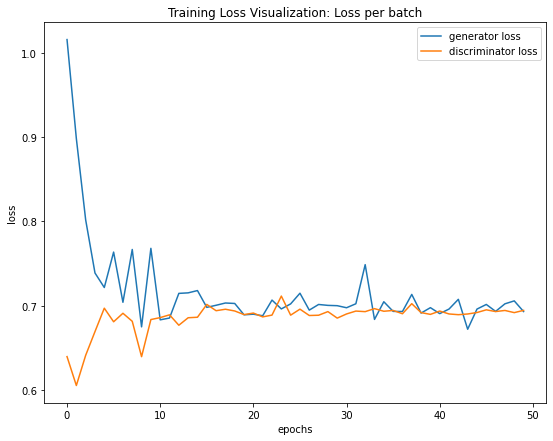

In [37]:
# Visualize training losses
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['train_generator_loss_per_batch'] for e in training_metrics.keys()], label = 'generator loss')
plt.plot([training_metrics[e]['train_discriminator_loss_per_batch'] for e in training_metrics.keys()], label = 'discriminator loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training Loss Visualization: Loss per batch")
plt.legend(loc = 'best')
plt.show()

### Use trained _generator_ to generate images from randomly sampled noise vector

In [38]:
# Get trained generator output using 'fixed_noise' from above-
generator_output = model.generator_forward(fixed_noise).cpu().detach().numpy()

In [39]:
# Sanity check-
generator_output.shape

(256, 1, 28, 28)

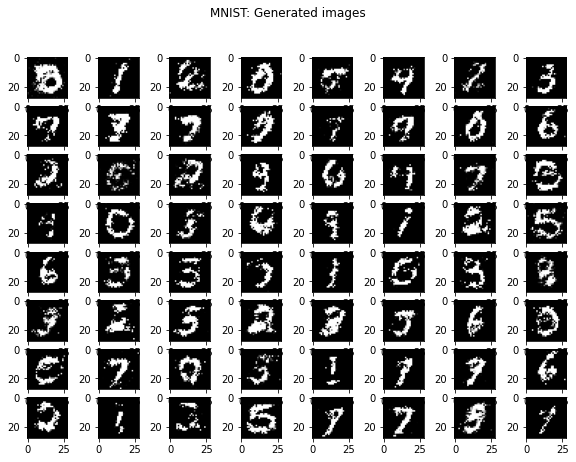

In [40]:
# Print 64 generated images-
plt.figure(figsize = (10, 7))
for i in range(64):
    # 8 rows & 8 columns-
    plt.subplot(8, 8, i + 1)
    # '0' to access first channel-
    plt.imshow(generator_output[i][0], cmap = 'gray')

plt.suptitle("MNIST: Generated images")
plt.show()

In [41]:
# Use a new noise vector: Generate batch of latent noise vector for
# evaluating/visualizing the training progress of generator-
another_fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device = device)

In [42]:
# Sanity check-
another_fixed_noise.shape

torch.Size([256, 100, 1, 1])

In [43]:
# Get generator's output/predictions using new noise vector-
generator_output = model.generator_forward(another_fixed_noise).cpu().detach().numpy()

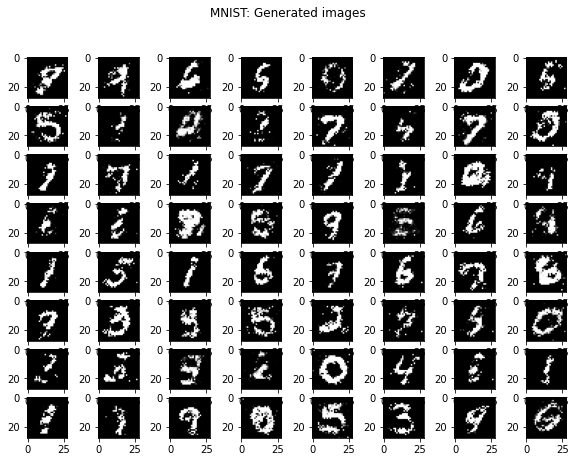

In [44]:
# Print 64 generated images-
plt.figure(figsize = (10, 7))
for i in range(64):
    # 8 rows & 8 columns-
    plt.subplot(8, 8, i + 1)
    # '0' to access first channel-
    plt.imshow(generator_output[i][0], cmap = 'gray')

plt.suptitle("MNIST: Generated images")
plt.show()

In [45]:
del another_fixed_noise

In [46]:
# Load 'best' trained parameters for generator-
trained_model_generator = GAN(
    latent_dim = 100, image_height = 28,
    image_width = 28, color_channels = 1
).to(device)

In [47]:
trained_model_generator.generator.load_state_dict(torch.load("GAN_Fully_Connected_MNIST_best_generator_parameters.pth"))

<All keys matched successfully>

In [48]:
# Get trained generator output using 'best' generator and 'fixed_noise'-
generator_output = trained_model_generator.generator_forward(fixed_noise).cpu().detach().numpy()

In [49]:
# Sanity check-
generator_output.shape

(256, 1, 28, 28)

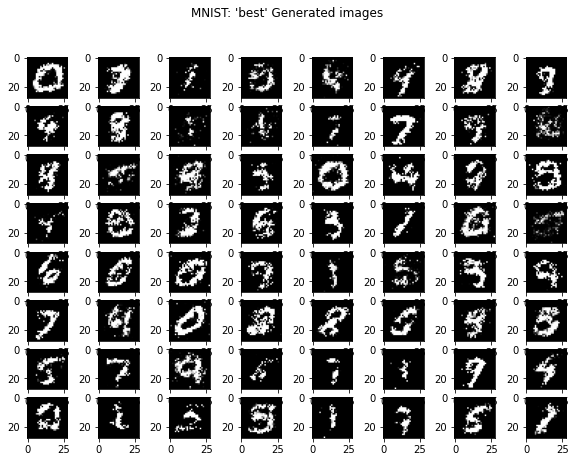

In [50]:
# Print 64 generated images-
plt.figure(figsize = (10, 7))
for i in range(64):
    # 8 rows & 8 columns-
    plt.subplot(8, 8, i + 1)
    # '0' to access first channel-
    plt.imshow(generator_output[i][0], cmap = 'gray')

plt.suptitle("MNIST: 'best' Generated images")
plt.show()

In [51]:
# Use a new noise vector: Generate batch of latent noise vector for
# evaluating/visualizing the training progress of generator-
another_fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device = device)

In [52]:
# Sanity check-
another_fixed_noise.shape

torch.Size([256, 100, 1, 1])

In [53]:
# Get generator's output/predictions using new noise vector-
generator_output = trained_model_generator.generator_forward(another_fixed_noise).cpu().detach().numpy()

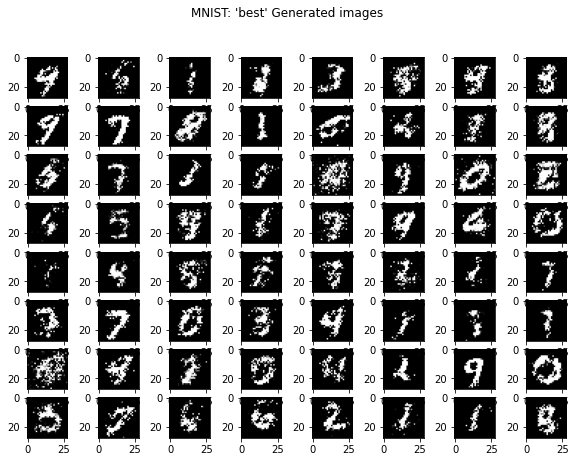

In [54]:
# Print 64 generated images-
plt.figure(figsize = (10, 7))
for i in range(64):
    # 8 rows & 8 columns-
    plt.subplot(8, 8, i + 1)
    # '0' to access first channel-
    plt.imshow(generator_output[i][0], cmap = 'gray')

plt.suptitle("MNIST: 'best' Generated images")
plt.show()

In [55]:
del another_fixed_noise

In [56]:
del trained_model_generator